In [3]:
# Made on the basis of:
# http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

LOG_DIR = '/tmp/tf/mnist_embeddings'
NAME_TO_VISUALISE_VARIABLE = "mnistembeddings"
TO_EMBED_COUNT = 500

MNIST_SPRITES =  os.path.join(LOG_DIR,'mnistdigits.png')
MNIST_METADATA =  os.path.join(LOG_DIR,'metadata.tsv')

In [4]:
# Eventually clear the log dir.
if tf.gfile.Exists(LOG_DIR):
  tf.gfile.DeleteRecursively(LOG_DIR)
# Create (new) log dir.
tf.gfile.MakeDirs(LOG_DIR)

### Download and extract MNIST

In [5]:
mnist = input_data.read_data_sets("/home/tkornuta/data/mnist", one_hot=False)
batch_xs, batch_ys = mnist.train.next_batch(TO_EMBED_COUNT)

Extracting /home/tkornuta/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/tkornuta/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/tkornuta/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/tkornuta/data/mnist/t10k-labels-idx1-ubyte.gz


### Creating the embeddings

In [6]:
embedding_var = tf.Variable(batch_xs, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

### Create the embedding projector

In [7]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = MNIST_METADATA #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = MNIST_SPRITES #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([28,28])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

### Saving the data

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'/tmp/tf/mnist_embeddings/model.ckpt-1'

### Visualisation helper functions

In [9]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits

### Save the sprite image

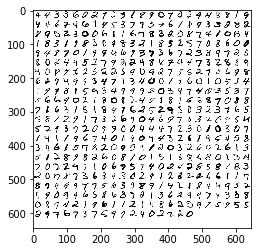

In [10]:
to_visualise = batch_xs
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.imsave(MNIST_SPRITES,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')
plt.show()

In [11]:

with open(MNIST_METADATA,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(batch_ys):
        f.write("%d\t%d\n" % (index,label))